In [39]:
import numpy as np
import cvxpy as cvx
import itertools

n = 20 # number of assets
K = int(n*(n-1)/2)# number of scenarios

# Monte Carlo sample
MC_N_SAMPLES = 100
MC_T = 50

N_TRAJ = 30
OFFSET = 2


std = 0.5
seed = 2018
print('seed', seed)
np.random.seed(seed)

uncertain_ratio_star = 0.15
# #### Helper functions 

def simulate_trajectories(sampled_returns, b):
    """Simulate log-wealth trajectories."""
    N_SAMPLES, T, n = sampled_returns.shape
    return np.hstack([np.zeros((N_SAMPLES, 1)),
                      np.cumsum(np.log(np.dot(sampled_returns, b)), axis=1)])

def growth_rate_Wmins(logw_samples):
    """Simulate expected log growth rate and samples W_min."""
    T = logw_samples.shape[1] - 1
    return mean(logw_samples[:,-1])/T, np.exp(np.min(logw_samples, axis=1))

def drawdown_prob(W_mins, alpha):
    return sum(W_mins < alpha)/float(len(W_mins))

def empirical_cdf(samples, grid):
    return array([sum(samples <= el) for el in grid], dtype=float) / len(samples)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

# # Definitions 

skill = np.random.randn(n)


beta = softmax( std*(skill))
beta /= sum(beta)

TopTwoList = list(itertools.combinations(range(n),2))

pi = np.ones(K)

r = np.zeros((n,K))


for count in range(len(TopTwoList)):
    vector = np.zeros(n)
    first_place = TopTwoList[count][0]
    second_place = TopTwoList[count][1]
    total = beta[first_place]+beta[second_place]
    vector[first_place] = n*beta[second_place]/total
    vector[second_place] = n*beta[first_place]/total
    r[:,count]=vector

    pi[count] = beta[second_place]*beta[first_place]*(1/(1-beta[first_place])+ 1/(1-beta[second_place]))
    
pi /= sum(pi)



mc_sample = r[:, np.random.choice(r.shape[1], size = MC_N_SAMPLES * MC_T, p = pi)]



# generate_box_prob
pi_0 = cvx.Parameter(K, nonneg=True)
rho = cvx.Parameter(K, nonneg=True)
b = cvx.Variable(n)
mu = cvx.Variable(K)
log_growth = cvx.log(r.T*b )
rob_growth_rate = cvx.min(log_growth + mu  )
rob_growth_rate = rob_growth_rate -pi_0.T*cvx.abs(mu  )-rho.T*mu 
constraints = [cvx.sum(b ) == 1, b  >= 0] 
robust_Kelly= cvx.Problem(cvx.Maximize(rob_growth_rate), constraints)

probl_rob = robust_Kelly










seed 2018


Kelly:uncertain_ratio 0.0
bet new [0.0386057  0.05799306 0.11461769 0.02373684 0.05587755 0.06583844
 0.0411668  0.04644196 0.0316584  0.05410732 0.05608551 0.04072895
 0.02291181 0.05704791 0.07801746 0.07279627 0.02454967 0.03805531
 0.02645561 0.05331255]
Wealth!!!
0.04777859940046155
Kelly:uncertain_ratio 0.15
bet new [0.05227266 0.05556985 0.05556595 0.03194107 0.05557009 0.05557
 0.05556932 0.05556991 0.04273486 0.05556978 0.05556975 0.05520038
 0.03082158 0.05556977 0.05557104 0.05557115 0.03304468 0.05151408
 0.03563653 0.05556891]
Wealth!!!
0.025350056527302763


<Figure size 864x432 with 0 Axes>

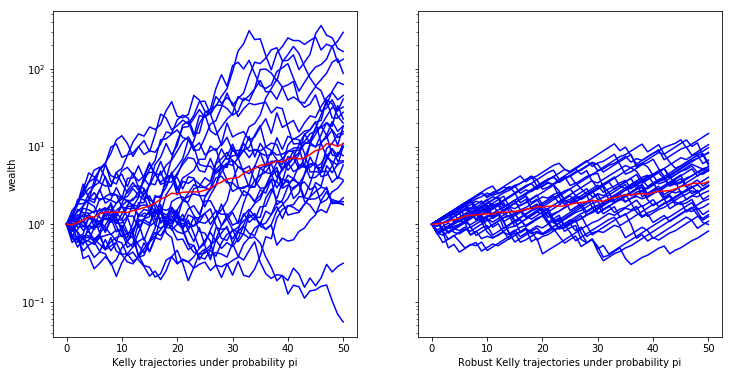

<Figure size 864x432 with 0 Axes>

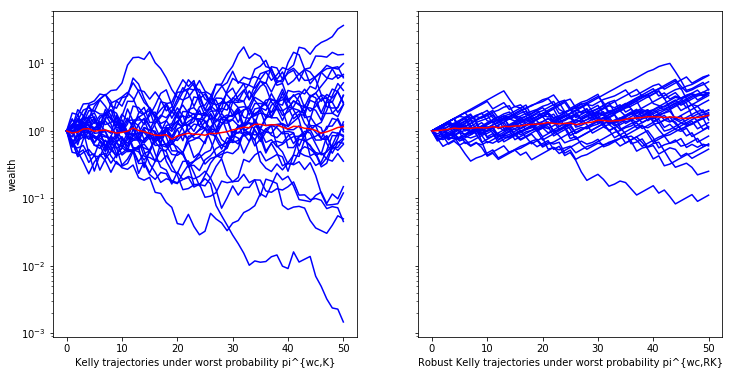

Wealth:
0.04285361182298182
0.023797585931360728
0.007519131409819226
0.01152487997440725


In [40]:


##########

B = []
L_growth = []

# pi_0 is true
pi_0.value = pi

figure(figsize(12,6))
f, (ax1, ax2) = subplots(1, 2, sharey=True)
ax1.set_xlabel("Kelly trajectories under probability pi")
ax2.set_xlabel("Robust Kelly trajectories under probability pi")
ax1.set_ylabel("wealth")
# ax1.legend(loc='upper left')


for ax, uncertain_ratio in zip([ax1, ax2], [0., uncertain_ratio_star]):

    bound = uncertain_ratio *pi

    rho.value = bound

    probl_rob.solve(solver = 'SCS')

    print('Kelly:uncertain_ratio',uncertain_ratio)
    print('bet new',b.value)
    B.append(b.value)
    L_growth.append(log_growth.value)


    logw_samples = simulate_trajectories(np.reshape(mc_sample[:, OFFSET:OFFSET+N_TRAJ*MC_T].T, 
                                                    (N_TRAJ, MC_T, n)), 
                                         b.value)

    for i in range(N_TRAJ): 
        wealth = np.exp(logw_samples[i,:])
        ax.semilogy(wealth, 'b') 


    ave_wealth = np.mean(np.exp(logw_samples[:,:]),axis = 0)
    ave_logwealth = np.mean((logw_samples[:,:]),axis = 0)
    exp_ave_logwealth = np.exp(ave_logwealth)

    ax.semilogy(exp_ave_logwealth, 'r')

    print('Wealth!!!')
    print(ave_logwealth[-1]/50) 


################

# find worst deviation for Kelly
delta0 = cvx.Variable(K)

constraints = [cvx.sum(delta0 ) == 0, pi+delta0 >= 0, cvx.abs(delta0)<= bound] 
worst_Prob= cvx.Problem(cvx.Minimize(delta0.T*L_growth[0]), constraints)

worst_Prob.solve(solver = 'SCS')
Delta0 = delta0.value



# find worst deviation for DRKP
delta1 = cvx.Variable(K)

constraints = [cvx.sum(delta1 ) == 0, pi+delta1 >= 0, cvx.abs(delta1)<= bound] 
worst_Prob= cvx.Problem(cvx.Minimize(delta1.T*L_growth[1]), constraints)

worst_Prob.solve(solver = 'SCS')
Delta1 = delta1.value





pi_Kw = pi+Delta0
pi_RKw = pi+Delta1
pi_Kw = np.maximum(0,pi_Kw)
pi_RKw = np.maximum(0,pi_RKw)
pi_Kw /= sum(pi_Kw)
pi_RKw /= sum(pi_RKw)



mc_sample_Kw = r[:, np.random.choice(r.shape[1], size = MC_N_SAMPLES * MC_T, p = pi_Kw)]
mc_sample_RKw = r[:, np.random.choice(r.shape[1], size = MC_N_SAMPLES * MC_T, p = pi_RKw)]

logw_samples_Kw = simulate_trajectories(np.reshape(mc_sample_Kw[:, OFFSET:OFFSET+N_TRAJ*MC_T].T, 
                                                    (N_TRAJ, MC_T, n)), 
                                         B[0])

logw_samples_RKw = simulate_trajectories(np.reshape(mc_sample_RKw[:, OFFSET:OFFSET+N_TRAJ*MC_T].T, 
                                                    (N_TRAJ, MC_T, n)), 
                                         B[1])



figure(figsize(12,6))
f, (ax1, ax2) = subplots(1, 2, sharey=True)

ax1.set_xlabel("Kelly trajectories under worst probability pi^{wc,K}")
ax2.set_xlabel("Robust Kelly trajectories under worst probability pi^{wc,RK}")
ax1.set_ylabel("wealth")


for i in range(N_TRAJ): 
    wealth = np.exp(logw_samples_Kw[i,:])
    ax1.semilogy(wealth, 'b') 

ave_wealth = np.mean(np.exp(logw_samples_Kw[:,:]),axis = 0)
ave_logwealth = np.mean((logw_samples_Kw[:,:]),axis = 0)
exp_ave_logwealth = np.exp(ave_logwealth)
ax1.semilogy(exp_ave_logwealth, 'r')    
for i in range(N_TRAJ): 
    wealth = np.exp(logw_samples_RKw[i,:])
    ax2.semilogy(wealth, 'b') 
ave_wealth = np.mean(np.exp(logw_samples_RKw[:,:]),axis = 0)
ave_logwealth = np.mean((logw_samples_RKw[:,:]),axis = 0)
exp_ave_logwealth = np.exp(ave_logwealth) 
ax2.semilogy(exp_ave_logwealth, 'r')   


plt.show()



#####################


print("Wealth:")
print(pi.dot(L_growth[0]))
print(pi.dot(L_growth[1]))
print(pi_Kw.dot(L_growth[0]))
print(pi_RKw.dot(L_growth[1]))








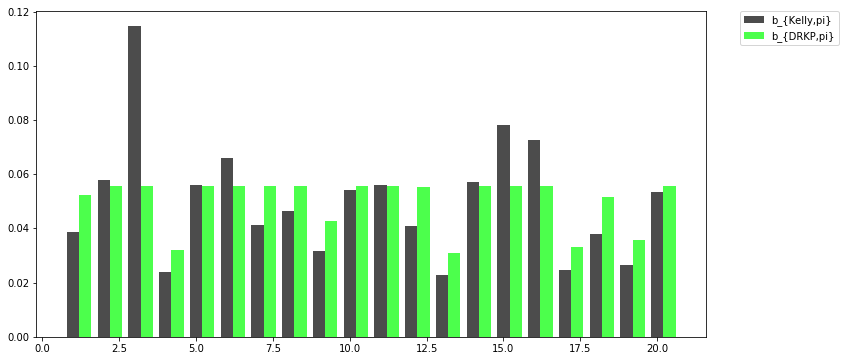

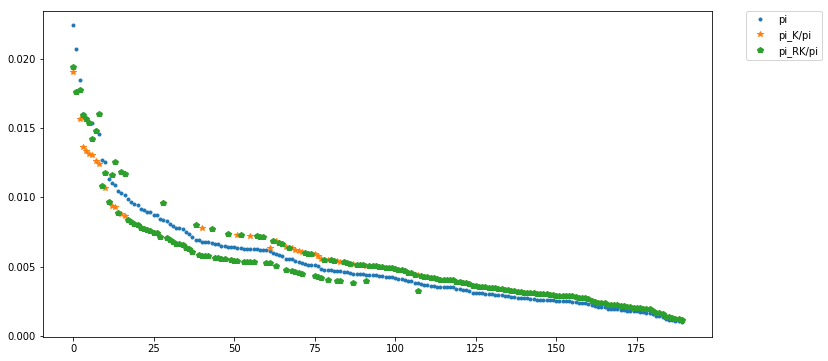

In [41]:

plt.subplot(111)
width = 0.4
barWidth = 0.4
plt.bar(  np.arange(1,n+1), B[0], width=barWidth, label='b_{Kelly,pi}',lw=1,alpha = 0.7, fc=(0, 0, 0, 0.5))
plt.bar(  np.arange(1,n+1)+ width, B[1],width=barWidth, label='b_{DRKP,pi}', lw=1,alpha = 0.7, fc=(0, 1, 0, 1))

# Place a legend to the right of this smaller subplot.
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

plt.subplot(111)
width = 0.2
barWidth = 0.4

order = np.argsort(pi)[::-1]
plt.plot(  pi[order] , '.', label='pi')
plt.plot(  pi_Kw[order], '*', label='pi_K/pi')
plt.plot(  pi_RKw[order], 'p' ,label='pi_RK/pi')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()


